# COVID - 19: Modeling, Prediction, and Control
Younes, B, A., & Hasan, Z. (2020). Covid-19: Modeling, prediction, and Control. Applied Sciences, 10(11), 3666. https://doi.org/10.3390/app10113666 

Jay Hwasung Jung \
CSYS 296: Computational Systems Biology \
David Bernstein\
Final Project


### Abstract
COVID-19 generalized Lotka-Volterra (gLV) and Extended Kalman Filter (EKF)


In [1]:
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [2]:
# covid19 daily cases imported
df = pd.read_csv('covid19.csv', sep=',')
df['real_datetime'] = np.array((pd.to_datetime(time, format="%m/%d/%Y") for time in df['ObservationDate']))

# covid19 world daily cases from January 22, 2020 to March 31, 2020 based on the paper
df_world = df[df['real_datetime'] >= dt.datetime(2020, 1, 22)]
df_world_extended = df_world[df_world['real_datetime'] <= dt.datetime(2020, 4, 14)]
df_world = df_world[df_world['real_datetime'] <= dt.datetime(2020, 3, 31)]

# get total number of cases
# world 1/22/2020 - 3/31/2020
df_world = df_world.groupby(['real_datetime']).agg(
    {'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

# world extended 1/22/2020 - 4/14/2020
df_world_extended = df_world_extended.groupby(['real_datetime']).agg(
    {'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})


df_world = pd.DataFrame(data = df_world['Confirmed'].values/10000, index = np.arange(len(df_world)), columns = ['daily_cases'])
df_world_extended = pd.DataFrame(data = df_world_extended['Confirmed'].values/10000, index = np.arange(len(df_world_extended)), columns = ['daily_cases'])

df_world['day'] = np.arange(len(df_world))
df_world_extended['day'] = np.arange(len(df_world_extended))


# US
df_us = df[df['Country/Region'] == 'US']

# covid19 us daily cases from January 22, 2020 to March 31, 2020 based on the paper
df_us = df_us[df_us['real_datetime'] >= dt.datetime(2020, 1, 22)]
df_us_extended = df_us[df_us['real_datetime'] <= dt.datetime(2020, 4, 14)]
df_us = df_us[df_us['real_datetime'] <= dt.datetime(2020, 3, 31)]


# get total number of cases
# US 1/22/2020 - 3/31/2020
df_us = df_us.groupby(['real_datetime']).agg(
    {'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

# US 1/22/2020 - 4/14/2020
df_us_extended = df_us_extended.groupby(['real_datetime']).agg(
    {'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})

df_us = pd.DataFrame(data = df_us['Confirmed'].values/10000, index = np.arange(len(df_us)), columns = ['daily_cases'])
df_us_extended = pd.DataFrame(data = df_us_extended['Confirmed'].values/10000, index = np.arange(len(df_us_extended)), columns = ['daily_cases'])

df_us['day'] = np.arange(len(df_us))
df_us_extended['day'] = np.arange(len(df_us_extended))

Text(0, 0.5, 'Daily Cases (1/10000)')

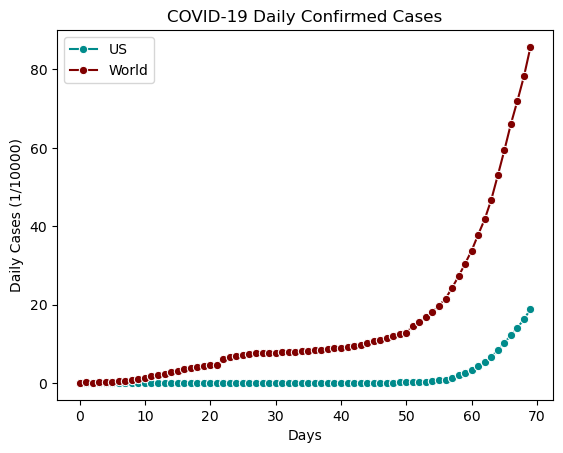

In [3]:
# US & World daily confirmed cases
sns.lineplot(data=df_us, x='day', y='daily_cases', marker='o', color='darkcyan')
sns.lineplot(data=df_world, x='day', y='daily_cases', marker='o', color='maroon')

plt.title('COVID-19 Daily Confirmed Cases')
plt.legend(['US', 'World'])
plt.xlabel('Days')
plt.ylabel('Daily Cases (1/10000)')

### Statistical Power Series Model

$\large y_j = \sum_{n=1}^N a_nt^n$; $j = 0,1,...,M$

According to the paper (Younes and Hasan, 2020), the statistical power series model

In [4]:
# Due to the differnece in datasets, the function below does not work, 
# so I decided to create my own polynomical regression using Numpy

def y_global_stat(t):
    return t**3 - 78*t**2 + 1600*t - 5300

def y_us_stat(t):
    return 0.0097*t**4 - t**3 + 33*t**2 - 3700*t + 9900


In [5]:

# polynomical regression model for global prediction
y_global = np.poly1d(np.polyfit(df_world['day'], df_world['daily_cases'], 4))
y_us = np.poly1d(np.polyfit(df_us['day'], df_us['daily_cases'], 4))

# get prediction for 14 days
y_global_predict = pd.DataFrame(data = np.array([y_global(t) for t in range(0,len(df_world_extended))]), 
                        columns = ['daily_cases'], 
                        index = np.arange(len(df_world_extended)))
y_us_predict = pd.DataFrame(data = np.array([y_us(t) for t in range(0,len(df_us_extended))]), 
                        columns = ['daily_cases'], 
                        index = np.arange(len(df_us_extended)))


y_global_predict['day'] = np.arange(len(y_global_predict))
y_us_predict['day'] = np.arange(len(y_us_predict))

Text(0, 0.5, 'Daily Cases (1/10000)')

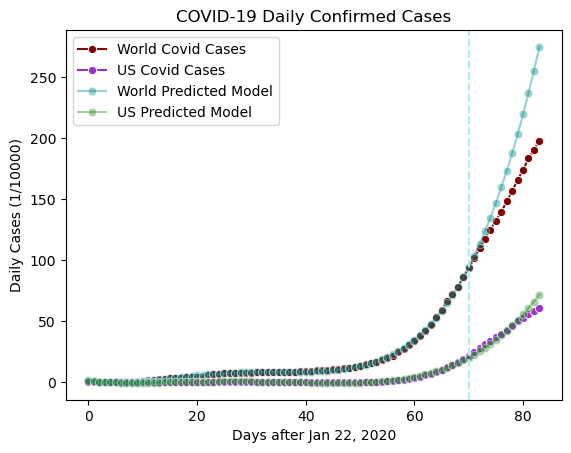

In [6]:
# US daily confirmed cases
sns.lineplot(data=df_world_extended, x='day', y='daily_cases', marker='o', color='maroon')
sns.lineplot(data=df_us_extended, x='day', y='daily_cases', marker='o', color='darkorchid')

sns.lineplot(data=y_global_predict, x='day', y='daily_cases', marker='o', color='darkcyan', alpha=0.4)
sns.lineplot(data=y_us_predict, x='day', y='daily_cases', marker='o', color='forestgreen', alpha=0.4)

plt.axvline(x = 70, linestyle ="--", color = "paleturquoise")

plt.title('COVID-19 Daily Confirmed Cases')
plt.legend(['World Covid Cases', 'US Covid Cases','World Predicted Model', 'US Predicted Model'])
plt.xlabel('Days after Jan 22, 2020')
plt.ylabel('Daily Cases (1/10000)')

### Generalized Lokta-Volterra Model

Dynamic models play important roles in describing the interationcs among specific behabior. 

Let {$x_i(t); i = 1,..., N$} be the relative abundance level of the $i$th species at time $t$ whose intrinsic growth rate is $g_i$. Let $c_{ij}$ represent the strenth of the influence of species $i$ onto species $j$ (or interaction coefficient). 

Below is the gLV model:

$\large \frac{d}{dt}x_i(t) = g_ix_i(t) + x_i(t)\sum_{j=1}^{N}c_{ij}x_j(t)$

$i = 1, ..., N$

To model effects of external perturbations (e.g. antibiotics and diets) onto the microbial community structure, Younes and Hasan (2020) added another term to which modulates the influence of each simulating source into each member of the ecosystem.

$\epsilon_{il}$ represent the sensitivity of the $i$th species in response to $l$th behaviour or control action with signal strength $u_l$

$\large \frac{d}{dt}x_i(t) = g_ix_i(t) + x_i(t)\sum_{j=1}^{N}c_{ij}x_j(t) + x_i(t)\sum_{l=1}^{L}\epsilon_{il}u_l(t)$

The proposed COVID-19 dynamic model 

<img src="./(1).png">

